In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
# Data loader
DATA_DIR = Path('../data/embeddings')
block_names = [f"{i:03d}.parquet" for i in range(1)]

block_paths = [DATA_DIR / block_name for block_name in block_names]
blocks = [pd.read_parquet(block_path) for block_path in block_paths]
dataset = pd.concat(blocks, axis=0)

def flatten(column):
    return np.array([np.array(x) for x in column])

Clustering 10000 tweets


/home/anantajit/data/Bluesky-Discourse-Forecasting/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/anantajit/data/Bluesky-Discourse-Forecasting/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/anantajit/data/Bluesky-Discourse-Forecasting/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/anantajit/data/Bluesky-Discourse-Forecastin

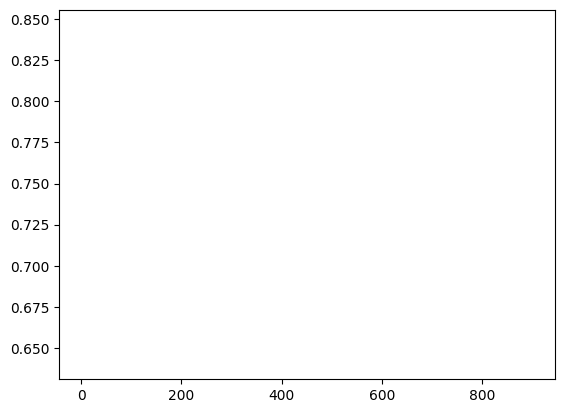

In [6]:
print(f"Clustering {dataset.shape[0]} tweets")

for k in range(1, 1000, 100):
    clusters = KMeans(n_clusters=k, random_state=0).fit(flatten(dataset['embeddings']))

    MSE = np.mean(np.min(clusters.transform(flatten(dataset['embeddings'])), axis=1))

    plt.plot(k, MSE)

/home/anantajit/data/Bluesky-Discourse-Forecasting/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Plotting class [0.29779629 0.53709512]
Original vector center:  [-0.07485712  0.00496838  0.03485395 ... -0.03476886  0.00451486
 -0.00960844]
Plotting class [-0.19684334 -0.01473749]
Original vector center:  [-0.03419229  0.06374498  0.00640427 ... -0.0164916   0.01459211
  0.00339313]
Plotting class [ 0.01111372 -0.14095929]
Original vector center:  [-0.03943982  0.01690294  0.02171682 ... -0.01803911  0.00424863
 -0.00475701]
Plotting class [-0.10060345 -0.00407315]
Original vector center:  [-0.02333934  0.00485007  0.0179452  ... -0.01287422 -0.00331426
 -0.00675148]


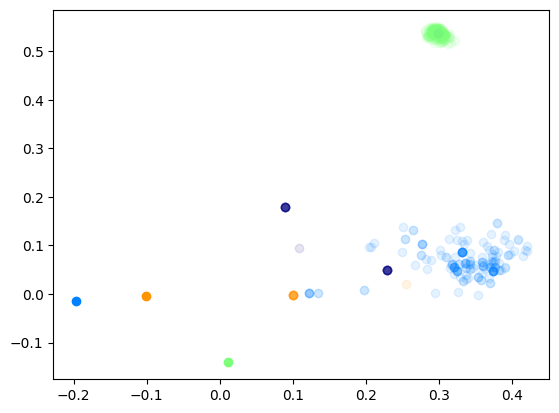

In [26]:
k = 100
clusters = KMeans(n_clusters=k, random_state=0).fit(flatten(dataset['embeddings']))
MSE = np.mean(np.min(clusters.transform(flatten(dataset['embeddings'])), axis=1))

class_labels = clusters.predict(flatten(dataset['embeddings']))
dataset['cluster'] = class_labels

class_mse = [np.mean(np.min(clusters.transform(flatten(dataset[dataset['cluster'] == i]['embeddings'])), axis=1)) for i in range(k)]

class_means = clusters.cluster_centers_

# tightest classes
class_ranks = np.argsort(class_mse)
best_classes = class_ranks[class_ranks < 4]

pca = PCA(n_components=2)
pca.fit(class_means)
pca_mean = pca.transform(class_means)
pca_datapoints = pca.transform(flatten(dataset['embeddings']))

cmap = plt.get_cmap('jet')

best_vectors = []

for i in range(len(best_classes)):
    print(f"Plotting class {pca_mean[best_classes[i], :]}")
    print("Original vector center: ", class_means[best_classes[i], :])
    best_vectors.append(class_means[best_classes[i], :])

    plt.scatter(pca_mean[best_classes[i], 0], pca_mean[best_classes[i], 1], color=cmap(i/len(best_classes)))

    pca_class_datapoints = pca_datapoints[dataset['cluster'] == class_ranks[best_classes[i]]]
    plt.scatter(pca_class_datapoints[:, 0], pca_class_datapoints[:, 1], color=cmap(i/len(best_classes)), alpha=0.1)


In [29]:
import torch
import torch.nn.functional as f
from sentence_transformers import SentenceTransformer
import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

model = SentenceTransformer("Alibaba-NLP/gte-Qwen2-1.5B-instruct", trust_remote_code=True)
model.to("cuda:2")
# In case you want to reduce the maximum length:
model.max_seq_length = 300

# decode embeddings
model.decode(best_vectors[0].reshape(1, -1))

using cuda


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]


AttributeError: 'SentenceTransformer' object has no attribute 'decode'